In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix

import numpy as np
import pandas as pd

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [7]:
## Need to define a scaling function that ignores categorical values...?

In [8]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total para

In [9]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.2)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.619, Acc:0.8771
Prediction Accuracy
25/25 [==============================] - 0s 2ms/step
Scores on data set: loss=0.816 accuracy=0.7600
Fold Correct: 19
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.640, Acc:0.8517
Prediction Accuracy
25/25 [==============================] - 0s 23us/step
Scores on data set: loss=0.609 accuracy=0.8400
Fold Correct: 21
Running worker: 2
Fold: 2 -> Loss:0.624, Acc:0.8782
Prediction Accuracy
24/24 [==============================] - 0s 24us/step
Scores on data set: loss=0.835 accuracy=0.7917
Fold Correct: 19
Running worker: 3
Fold: 3 -> Loss:0.611, Acc:0.8655
Prediction Accuracy
24/24 [==============================] - 0s 17us/step
Scores on data set: loss=0.728 accuracy=0.8333
Fold Correct: 20
Running worker: 4
Fold: 4 -> Loss:0.649, Acc:0.8361
Prediction Accuracy
24/24 [=====

Confusion matrix, without normalization
[[ 86  24]
 [ 19 113]]


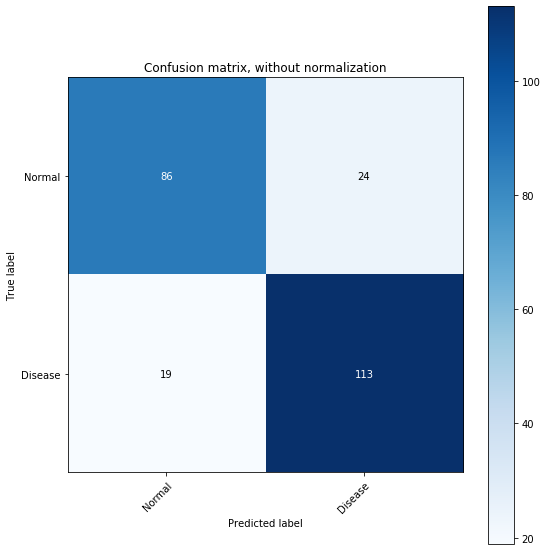

In [10]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

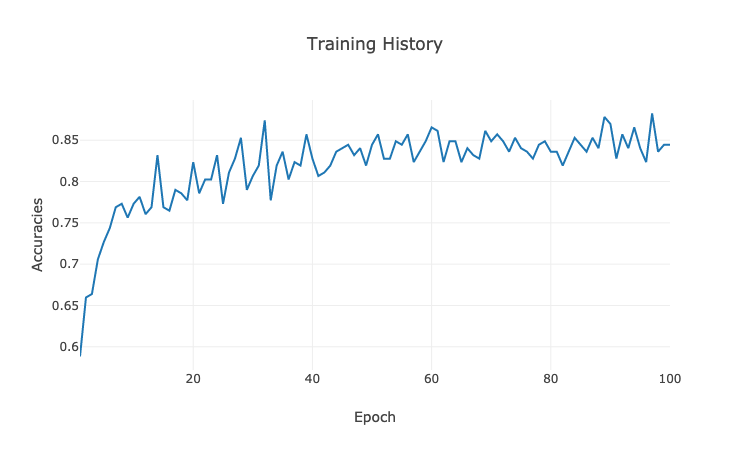

In [11]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [12]:
min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(min_cluster_sizes=min_cluster_sizes, plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:734

Minimum Size:
Clusters                  6
Noise                     3
Silhouette                4
Halkidi                   4
Halkidi-Filtered Noise    4
Halkidi-Bounded Noise     4
dtype: int64


,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
3,2,0.451327,-2.526266e-02,1.736550e+00,1.366312e+00,2.034999e+00
4,3,0.761062,-1.298017e-01,7.818654e-01,6.668737e-01,1.686204e+00
5,2,0.876106,-1.005194e-01,1.460669e+00,1.716673e+00,2.240850e+00
6,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
7,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
8,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
9,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
10,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
11,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
12,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [13]:
pd.Series(pipeline.clusterer.labels_).value_counts()

-1    86
 1    15
 2     7
 0     5
dtype: int64

In [14]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [15]:
pd.Series(cluster_labels).value_counts()

-1    31
dtype: int64

## Plotting Testing LRP

In [22]:
from sklearn.preprocessing import MinMaxScaler
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class
split_class_lrp = np.array(pipeline.lrp_results)[split_class]

lrp_data = np.clip(split_class_lrp, 0,None)
s_lrp_data = MinMaxScaler().fit_transform(lrp_data)

In [23]:
labels = correct_pred_labels[split_class]
len(labels)

113

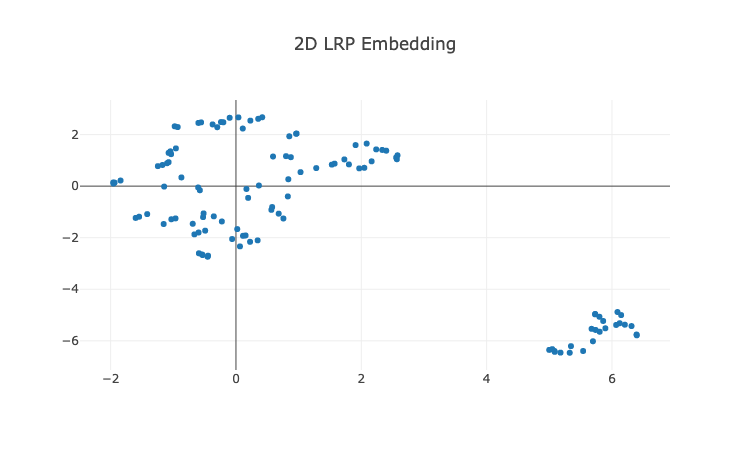

In [24]:
import umap
from matplotlib import pyplot as plt

reducer = umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=7,
                    min_dist=0)
embedding = reducer.fit_transform(s_lrp_data)

emb2d = go.Scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    mode="markers"
)

layout = go.Layout(
    title= "2D LRP Embedding"
)

data=[emb2d]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [88]:
from sklearn.pipeline import Pipeline

embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=7,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(lrp_data)

Pipeline(memory=None,
         steps=[('reducer',
                 UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
                      learning_rate=1.0, local_connectivity=1.0,
                      metric='euclidean', metric_kwds=None, min_dist=0,
                      n_components=3, n_epochs=None, n_neighbors=7,
                      negative_sample_rate=5, random_state=42,
                      repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
                      target_metric='categorical', target_metric_kwds=None,
                      target_n_neighbors=-1, target_weight=0.5,
                      transform_queue_size=4.0, transform_seed=42,
                      verbose=False)),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [89]:
embedding = embedding_pipeline.transform(lrp_data)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.5
#         ),
        opacity=0.8
    )
)

layout = go.Layout(
    title= "3D LRP Embedding"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')

## Plotting Validation LRP

In [90]:
val_target_class = pipeline.val_set.labels[pipeline.val_pred_mask] == pipeline.target_class

val_lrp = np.clip(pipeline.val_set_lrp, 0,None)
s_val_lrp = MinMaxScaler().fit_transform(val_lrp)

In [91]:
# reducer = umap.UMAP(random_state=42,
#                     n_components = 3,
#                     n_neighbors=7,
#                     min_dist=0)

val_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_embedding[:,0],
    y=val_embedding[:,1],
    z=val_embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
#             width=0.5,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

In [62]:
# # reducer = umap.UMAP(random_state=42,
# #                     n_components = 3,
# #                     n_neighbors=7,
# #                     min_dist=0)
# embedding = reducer.fit_transform(val_lrp)

# val_emb3d = go.Scatter3d(
#     x=val_lrp[:,2],
#     y=val_lrp[:,3],
#     z=val_lrp[:,6],
#     mode="markers",
#     marker=dict(
#         size=5,
#         color=pipeline.clusterer.labels_,
# #             width=0.5,
#         colorscale='Viridis',
#         opacity=0.8
#     )
# )

# layout = go.Layout(
#     title= "3D LRP Embedding",margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )

# data=[val_emb3d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='lrp-3d-scatter.html')

In [92]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=7,prediction_data=True)
clusterer.fit(embedding)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=7, min_samples=7, p=None,
        prediction_data=True)

In [93]:
pd.Series(clusterer.labels_).value_counts()

1    88
0    25
dtype: int64

In [95]:
layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

emb3d["marker"]["color"]=clusterer.labels_

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-val.html')

### Validation LRP after UMAP Embedding

In [96]:
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_embedding)
pd.Series(cluster_labels).value_counts()

1    26
0     5
dtype: int64

In [99]:
val_emb3d["marker"]["color"]=cluster_labels

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

In [100]:
data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

In [371]:
from s_dbw import S_Dbw

ii32 = np.iinfo(np.int32)

plot=False        # FIXME: Assumes 2D data only
if plot:
    plt.close("Cluster Comparison") #1+len(cluster_sizes)
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(15,6*(+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")

    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

_metrics = []
cluster_sizes = range(3,10)

for i,size in enumerate(cluster_sizes):
    min_samples = range(3,size+1)

    for j,min_s in enumerate(min_samples):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size, min_samples=min_s)
        clusterer.fit(lrp_data)
        cluster_labels = clusterer.labels_

        ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

    #     color_palette = sns.color_palette("bright", num_clusters)
    #     cluster_colors = [color_palette[x] if x >= 0
    #                     else (0, 0, 0)
    #                     for x in clusterer.labels_]
    #     cluster_member_colors = [sns.desaturate(x, p) for x, p in
    #                             zip(cluster_colors, clusterer.probabilities_)]

        # print(cluster_labels)
        noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind = [ii32.max]*4

        noise = list(cluster_labels).count(-1)/len(cluster_labels)

        if num_clusters > 1:
            halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')


        _metrics.append([num_clusters,noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])

        if plot:
            axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
            axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
            axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    if plot:
        plt.tight_layout()
        plt.show()
        plt.savefig(self.FIGUREDIR+"cluster_perf_comp.png")
        plt.close("Cluster Comparison")

In [372]:
index  = [y for x in cluster_sizes for y in list(zip([x]*x,range(3,x+1))) ]
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=index)
scores

,Clusters,Noise,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
"(3, 3)",2,0.455357,1.606198e+00,1.256263e+00,2.562221e+00
"(4, 3)",2,0.455357,1.606198e+00,1.256263e+00,2.562221e+00
"(4, 4)",2,0.562500,1.600622e+00,1.167805e+00,2.562221e+00
"(5, 3)",2,0.455357,1.606198e+00,1.256263e+00,2.562221e+00
"(5, 4)",2,0.562500,1.600622e+00,1.167805e+00,2.562221e+00
"(5, 5)",2,0.633929,1.542962e+00,1.231291e+00,1.680107e+00
"(6, 3)",2,0.455357,1.606198e+00,1.256263e+00,2.562221e+00
"(6, 4)",2,0.562500,1.600622e+00,1.167805e+00,2.562221e+00
"(6, 5)",2,0.633929,1.542962e+00,1.231291e+00,1.680107e+00
"(6, 6)",2,0.607143,1.835614e+00,1.176872e+00,1.928802e+00


In [381]:
scores.idxmin()

Clusters                  (8, 8)
Noise                     (3, 3)
Halkidi                   (5, 5)
Halkidi-Filtered Noise    (4, 4)
Halkidi-Bounded Noise     (5, 5)
dtype: object

In [385]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=4, prediction_data=True)
clusterer.fit(lrp_data)
pd.Series(clusterer.labels_).value_counts()

-1    63
 1    38
 0    11
dtype: int64

In [383]:
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=7,
                    min_dist=0)
embedding = reducer.fit_transform(lrp_data)

Index([(3, 3), (4, 3), (4, 4), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5),
       (6, 6), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (8, 3), (8, 4), (8, 5),
       (8, 6), (8, 7), (8, 8), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8),
       (9, 9)],
      dtype='object')